In [4]:
import os
import numpy as np
from dtw import dtw
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt



In [5]:
def similarity_DTW(s1, s2):
    ratio = 50 # 设定的放缩系数，避免数据的相似度过于集中
    euclidean_norm = lambda x, y: np.abs(ratio * (x - y))
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=euclidean_norm)
    score = 1 - np.tanh(d)  # 相似度的评分【0,1】 0： 完全不同， 1： 完全相同
    return score

DBA_cluster = np.load("./processing/DBA_wave.pkl", allow_pickle=True)
DBA_clustering_heatmap = np.zeros((len(DBA_cluster), len(DBA_cluster)))
id_list = list(DBA_cluster.keys())
for i, id in enumerate(tqdm(id_list)):
    s1 = DBA_cluster[id]
    for j in range(0, i+1):
        id_2 = id_list[j]
        s2 = DBA_cluster[id_2]
        score = similarity_DTW(s1, s2)
        DBA_clustering_heatmap[i][j] = score
        DBA_clustering_heatmap[j][i] = score

100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


          0         1         2         3         4
0  1.000000  0.684997  0.608530  0.662215  0.583947
1  0.684997  1.000000  0.725086  0.715269  0.564362
2  0.608530  0.725086  1.000000  0.620685  0.443661
3  0.662215  0.715269  0.620685  1.000000  0.519886
4  0.583947  0.564362  0.443661  0.519886  1.000000
[2, 3, 4, 0, 1]
['ClusterID2', 'ClusterID3', 'ClusterID4', 'ClusterID0', 'ClusterID1']
            ClusterID2  ClusterID3  ClusterID4  ClusterID0  ClusterID1
ClusterID2    1.000000    0.684997    0.608530    0.662215    0.583947
ClusterID3    0.684997    1.000000    0.725086    0.715269    0.564362
ClusterID4    0.608530    0.725086    1.000000    0.620685    0.443661
ClusterID0    0.662215    0.715269    0.620685    1.000000    0.519886
ClusterID1    0.583947    0.564362    0.443661    0.519886    1.000000


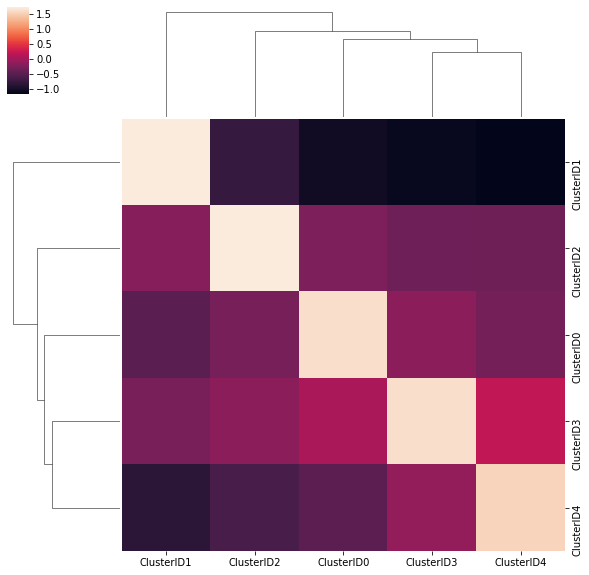

In [6]:
data_frame = pd.DataFrame(DBA_clustering_heatmap)
print(data_frame)

print(id_list)
cluster_id = ["ClusterID{}".format(x) for x in id_list]
print(cluster_id)
cluster_result = data_frame.rename(index=dict(zip(range(len(cluster_id)), cluster_id)), columns=dict(zip(range(len(cluster_id)), cluster_id)))
print(cluster_result)
# print(data_frame)

# metric数据度量方法, method计算聚类的方法
# standard_scale标准维度（0：行或1：列即每行或每列的含义，减去最小值并将每个维度除以其最大值）
# sns.clustermap(cluster_result, metric="correlation", method="single", cmap="Blues", standard_scale=1)
# sns.clustermap(cluster_result, standard_scale=1)
# Normalize 正则化
sns.clustermap(cluster_result, z_score=1)
plt.savefig("./pdf/cluster_heatmap.pdf")
plt.show()